# NEWA Meso-Micro Challenge for Wind Resource Assessment Phase 1: Benchmark Evaluation Script

Javier Sanz Rodrigo  <jsrodrigo@cener.com> 
National Renewable Energy Centre (CENER), Sarriguren, Spain

## Introduction
This benchmark script analyzes the simulations submitted to the first benchmark of the "NEWA Meso-Micro Challenge for Wind Resource Assessment", organized within the [NEWA](http://www.neweuropeanwindatlas.eu/) project and the [IEA Task 31 Wakebench](https://windbench.net/wakebench2). 
The results of this benchmark have been presented at the Torque 2018 Conference (Milan, 20-22 June 2018), published in:

**Sanz Rodrigo J, Chávez Arroyo R, Gancarski P, Borbón Guillén F, Avila M, Garcons J, Folch A, Cavar D, Allaerts D, Meyers J, Dutrieux A (2018) Comparing Meso-Micro Methodologies for Annual Wind Resource Assessment and Turbine Siting at Cabauw. Journal of Physics: Conference Series, to be published **

Please refer to this publication for additional explanations and discussions not included in this notebook.

## Benchmark Set-Up
Background information and benchmark set-up can be found in: 
* https://windbench.net/newa-meso-micro-challenge-wind-resource-assessment
* http://windbench.net/newa-meso-micro-challenge-phase1

## Simulations
The following simulations participate in the benchmark. Notice that *WRF-YSU (ref)* is the reference mesoscale simulation that was used to generate the mesoscale tendencies that are used as forcings for the microscale models. Additional WRF simulations have been run to test the sensitivity of mesoscale simulations to input forcing and planetary boundary layer (PBL) scheme. The ensemble mean of these WRF simulations is also used in the model intercomparison.

**Table 1. Summary of model simulations. Monin Obukhov similarity theory (Monin-Obukhov (MOST) surface boundary conditions use 2-m ($T_{2}$) or skin temperature ($T_{SK}$) from WRF.**

| Name | Input | Turbulence | z-Levels | Surface B.C. | 
|:----:|:-----:|:----------:|:--------:|:------------:|
| WRF-YSU (ref) | ERA-Interim | YSU | 46 | Noah |
| CFDWind1D_ke | WRF (ref) | $k-\epsilon$ | 301 | MOST, $T_2$|
| Ellipsys1D_ke | WRF (ref) | $k-\epsilon$ | 192 | MOST, $T_{SK}$ |
| SP-Wind_LES | WRF (ref) | LES-TKE | 200 | MOST, $T_2$ |


## Load libraries and define input data

In [54]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import pandas as pd
import netCDF4 
from windrose import WindroseAxes
from scipy import interpolate
import scipy.integrate as integrate
import statsmodels.api as sm
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
    
# Constants
g = 9.81    # [m s-2]
P0 = 100000 # Reference pressure [Pa]
T0 = 300    # Reference temperature for perturbation temperature [K]
kappa = 0.2854  # Poisson constant (R/Cp)
R_air = 287.058  # Specific gas constant for dry air [J kg-1 K-1]
Cp_air = 1005   # Specific heat of air [J kg-1 K-1]
omega = 7.2921159e-5    # angular speed of the Earth [rad/s]
K = 0.41    # von Karman constant

# Site 
siteID = 'Cabauw'
lat_s = 51.971   # degrees N
lon_s = 4.927    # degrees E
fc  = 2*omega*np.sin(lat_s*np.pi/180)     # Coriolis parameter [s-1]

# Evaluation period
datefrom = datetime.datetime(2006,1,1,0,0,0)
dateto = datetime.datetime(2006,12,30,23,50,0)
zref = 80.          # Choose a reference height corresponding to a measurement level 

# Load turbine data 
# NREL 5MW reference turbine
# courtesy of Jason Jonkman, https://wind.nrel.gov/forum/wind/viewtopic.php?t=1023
Hhub = 90.         # hub-height [m]
Drot = 126.         # rotor diameter [m]
Prated = 5000.     # rated power [kW]
dirwt = './'
filewt = 'NREL5MW_WindSpeedRelationships.txt' 
WT = pd.read_csv(dirwt+filewt, sep = '\t', header = [0,1], engine = 'python')
PwrCurve = interpolate.interp1d(WT['WindVxi'].values.flatten(),WT['GenPwr'].values.flatten(), 
                                bounds_error = False, fill_value = 0)
# print WT

## Load Observational data
Observational data from Cabauw has been retrieved from the CESAR database: http://www.cesar-database.nl/Welcome.do
The data has been reformatted to a standardized NetCDF file using the Cabauwobs2nc.py script

In [55]:
dirobs = './'
fileobs = 'Cabauw_mast_20060101_20061230.nc'
ts = 60     
nodata = -999.0
f = netCDF4.Dataset(dirobs+fileobs, 'r')

time_obs = f.variables['time'][:]    
datetime_obs = netCDF4.num2date(time_obs,units='hours since 0001-01-01 00:00:00.0',calendar='gregorian')

ifrom_obs=0
for j in range(1,len(datetime_obs)):
    if datetime_obs[j] <= datefrom:
        ifrom_obs = j

ito_obs=0
for j in range(1,len(datetime_obs)):
    if datetime_obs[j] <= dateto:
        ito_obs = j+1


datetime_obs = datetime_obs[ifrom_obs:ito_obs]

# sesonr heights
zT_obs = f.variables['zT'][:]
zS_obs = f.variables['zS'][:]
zWD_obs = f.variables['zWD'][:]
zflux_obs = f.variables['zflux'][:]

# Timeseries of variables
WD_obs = pd.DataFrame(f.variables['WD'][ifrom_obs:ito_obs], index = datetime_obs, columns = zWD_obs)
S_obs = pd.DataFrame(f.variables['S'][ifrom_obs:ito_obs], index = datetime_obs, columns = zS_obs)
Sstd_obs = pd.DataFrame(f.variables['Sstd'][ifrom_obs:ito_obs], index = datetime_obs, columns = zS_obs)
T_obs = pd.DataFrame(f.variables['T'][ifrom_obs:ito_obs], index = datetime_obs, columns = zT_obs)
us_obs = pd.DataFrame(f.variables['us'][ifrom_obs:ito_obs], index = datetime_obs, columns = zflux_obs)
wt_obs = pd.DataFrame(f.variables['wt'][ifrom_obs:ito_obs], index = datetime_obs, columns = zflux_obs)
zL_obs = zflux_obs/pd.DataFrame(f.variables['L'][ifrom_obs:ito_obs], index = datetime_obs, columns = zflux_obs)

I_obs = Sstd_obs/S_obs
I_obs[I_obs==float("inf")] = np.nan


## Load tendencies
For consistency with the GABLS3 precursor benchmark, a similar WRF setup was used in these year-long simulations to produce mesoscale tendencies for the microscale models. WRF-ARW v3.8 [8] was configured with a one-way nesting configuration based on three concentric square domains centred at the sites, as in Kleczek et al [13], based on a 61x61 points grid with 27, 9 and 3 km horizontal resolution. The vertical grid, approximately 13 km high, is based on 46 terrain-following (eta) levels with 24 levels in the first 1000 m, the first level at approximately 13 m, a uniform spacing of 25 m over the first 300 m and then stretched to a uniform resolution of 600 m in the upper part. The U.S. Geological Survey (USGS) land-use surface data, which comes by default with the WRF model, is used together with the unified Noah land-surface model to define the boundary conditions at the surface. Other physical parameterizations used are: the rapid radiative transfer model (RRTM), the Dudhia radiation scheme and the Yonsei University (YSU) first-order PBL scheme [14]. The simulation uses input data from ERA-Interim [15] with a spin-up time of 24 hours initialized every day at 12UTC.
During runtime, mesoscale tendencies are computed and stored in the standard output of WRF. Tendencies from the 3 km domain are averaged horizontally over a square box of 9-km length to filter out small scale fluctuations [16]. A sensitivity study and validation of mesoscale tendencies for the sites of this study is discussed in [17].

In [56]:
dirtend = '.'
filetend = '/Cabauw_tendencies_w60_L9000.nc'
f = netCDF4.Dataset(dirtend+filetend, 'r')
ztend = f.variables['z'][:]
times = f.variables['time'][:]
idates = np.where(np.logical_and(times >= mdates.date2num(datefrom), 
                             times < mdates.date2num(dateto)))[0] 
Ug = pd.DataFrame(f.variables['Ug'][idates], index = mdates.num2date(f.variables['time'][idates]), columns = ztend)
Vg = pd.DataFrame(f.variables['Vg'][idates], index = mdates.num2date(f.variables['time'][idates]), columns = ztend)
Uadv = pd.DataFrame(f.variables['Uadv'][idates], index = mdates.num2date(f.variables['time'][idates]), columns = ztend)
Vadv = pd.DataFrame(f.variables['Vadv'][idates], index = mdates.num2date(f.variables['time'][idates]), columns = ztend)
Thadv = pd.DataFrame(f.variables['Thadv'][idates], index = mdates.num2date(f.variables['time'][idates]), columns = ztend)
Ug.index.tz = None; Vg.index.tz = None; Uadv.index.tz = None; Vadv.index.tz = None; Thadv.index.tz = None


## Load simulation data

In [57]:
dirsim = '.'
filesim = [dirsim + '/WRF-YSU/WRF-YSU.nc',
           dirsim + '/CFDWind1D/CFDWind1D.nc',
           dirsim + '/EllipSys1D/EllipSys1D.nc',
           dirsim + '/SP-Wind/SP-Wind.nc']
simID = ['WRF-YSU','CFDWind1D','EllipSys1D','SP-Wind']
simtype = ['meso','micro','micro','micro']
Nsim = len(filesim)

t = []; U = []; V = []; Th = []; z = []; S = []; WD = []; us = []
wt = []; T2 = []; TKE = []; zL = []; I = []
for isim in range(0,Nsim):
    f = netCDF4.Dataset(filesim[isim], 'r')
    times = f.variables['time'][:]
    idates = np.where(np.logical_and(times >= mdates.date2num(datefrom), 
                                 times < mdates.date2num(dateto)))[0] 
    z.append(f.variables['z'][:])
    zflux = f.variables['zflux'][:]
    t.append(pd.DataFrame(f.variables['time'][idates], index = mdates.num2date(f.variables['time'][idates])))       
    U.append(pd.DataFrame(f.variables['U'][idates,:], index = mdates.num2date(f.variables['time'][idates]), columns = f.variables['z'][:]))
    V.append(pd.DataFrame(f.variables['V'][idates,:], index = mdates.num2date(f.variables['time'][idates]), columns = f.variables['z'][:]))
    Th.append(pd.DataFrame(f.variables['Th'][idates,:], index = mdates.num2date(f.variables['time'][idates]), columns = f.variables['z'][:]))
    TKE.append(pd.DataFrame(f.variables['TKE'][idates,:], index = mdates.num2date(f.variables['time'][idates]), columns = f.variables['z'][:]))    
    S.append((U[isim]**2 + V[isim]**2)**0.5)
    WD.append(180 + np.arctan2(U[isim],V[isim])*180/np.pi)
    I.append(np.sqrt(2./3.*TKE[isim])/S[isim])
    us.append(pd.DataFrame(f.variables['ust'][idates], index = mdates.num2date(f.variables['time'][idates]), columns = zflux))
    wt.append(pd.DataFrame(f.variables['wt'][idates], index = mdates.num2date(f.variables['time'][idates]), columns = zflux))
    T2.append(pd.DataFrame(f.variables['T2'][idates], index = mdates.num2date(f.variables['time'][idates]), columns = zflux))
    zL.append(zflux/(-us[isim]**3/(K*(g/T2[isim])*wt[isim])))
    U[isim].index.tz = None; V[isim].index.tz = None; Th[isim].index.tz = None; S[isim].index.tz = None     # this is to avoid bug in pd.concat below
    WD[isim].index.tz = None; us[isim].index.tz = None; wt[isim].index.tz = None; T2[isim].index.tz = None
    zL[isim].index.tz = None; I[isim].index.tz = None
    f.close()


# Resample to hourly data

In [58]:
ts = 60
WD_obs = WD_obs.resample(str(ts)+'Min').mean().bfill()
S_obs = S_obs.resample(str(ts)+'Min').mean().bfill()
T_obs = T_obs.resample(str(ts)+'Min').mean().bfill()
I_obs = I_obs.resample(str(ts)+'Min').mean().bfill()
us_obs = us_obs.resample(str(ts)+'Min').mean().bfill()
wt_obs = wt_obs.resample(str(ts)+'Min').mean().bfill()
zL_obs = zL_obs.resample(str(ts)+'Min').mean().bfill()
Ug = Ug.resample(str(ts)+'Min').mean().bfill()
Vg = Vg.resample(str(ts)+'Min').mean().bfill()
Uadv = Uadv.resample(str(ts)+'Min').mean().bfill()
Vadv = Vadv.resample(str(ts)+'Min').mean().bfill()
Thadv = Thadv.resample(str(ts)+'Min').mean().bfill()
Sadv = (Uadv**2 + Vadv**2)**0.5
WDadv = 180 + np.arctan2(U[isim],V[isim])*180/np.pi
Th_obs = T_obs + (g/Cp_air)*zT_obs
U_obs = S_obs*np.cos((270.-WD_obs)*np.pi/180)
V_obs = S_obs*np.sin((270.-WD_obs)*np.pi/180)

for isim in range(0,Nsim):
    U[isim] = U[isim].resample(str(ts)+'Min').mean().bfill()
    V[isim] = V[isim].resample(str(ts)+'Min').mean().bfill()
    WD[isim] = WD[isim].resample(str(ts)+'Min').mean().bfill()
    S[isim] = S[isim].resample(str(ts)+'Min').mean().bfill()
    Th[isim] = Th[isim].resample(str(ts)+'Min').mean().bfill()
    I[isim] = I[isim].resample(str(ts)+'Min').mean().bfill()
    us[isim] = us[isim].resample(str(ts)+'Min').mean().bfill()
    wt[isim] = wt[isim].resample(str(ts)+'Min').mean().bfill()
    zL[isim] = zL[isim].resample(str(ts)+'Min').mean().bfill()


## Interpolate to reference height
This will be used as reference to filter data in the definition of wind classes.

In [59]:
S_obs['zref'] = interpolate.interp1d(zS_obs, S_obs[S_obs.columns.values])(zref)
WD_obs['zref'] = interpolate.interp1d(zWD_obs, WD_obs[WD_obs.columns.values])(zref)
Th_obs['zref'] = interpolate.interp1d(zT_obs, Th_obs[Th_obs.columns.values])(zref)
I_obs['zref'] = interpolate.interp1d(zS_obs, I_obs[I_obs.columns.values])(zref)

for isim in range(0,Nsim):
    S[isim]['zref'] = interpolate.interp1d(z[isim], S[isim][S[isim].columns.values])(zref)
    WD[isim]['zref'] = interpolate.interp1d(z[isim], WD[isim][WD[isim].columns.values])(zref)
    Th[isim]['zref'] = interpolate.interp1d(z[isim], Th[isim][Th[isim].columns.values])(zref)
    I[isim]['zref'] = interpolate.interp1d(z[isim], I[isim][I[isim].columns.values])(zref)


## Plot time series
Select a period to plot reference quantities.

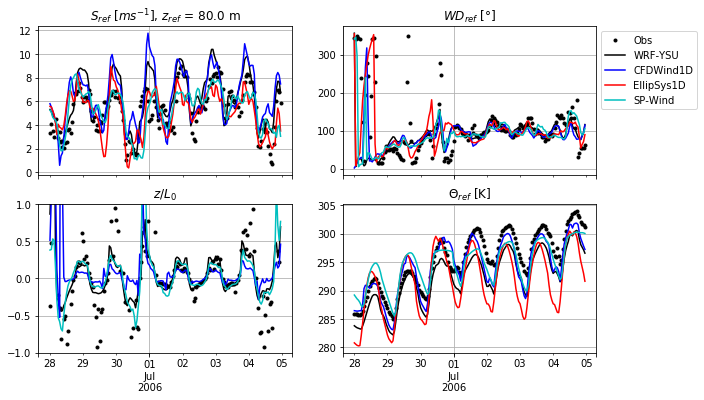

**Fig 1. Time series of reference quantities.**

In [60]:
datefromplot = datetime.datetime(2006,6,28,0,0,0)
datetoplot = datetime.datetime(2006,7,4,23,50,0)

Splot = S_obs['zref'][datefromplot:datetoplot].rename('Obs')
WDplot = WD_obs['zref'][datefromplot:datetoplot].rename('Obs')
Thplot = Th_obs['zref'][datefromplot:datetoplot].rename('Obs')
usplot = us_obs[datefromplot:datetoplot]
usplot.columns = ['Obs']
zLplot = zL_obs[datefromplot:datetoplot]
zLplot.columns = ['Obs']

for isim in range(0,Nsim):  # interpolate simulation data to zref
    subset = S[isim]['zref'][datefromplot:datetoplot].rename(simID[isim])    
    Splot = pd.concat([Splot,subset], axis = 1)
    subset = WD[isim]['zref'][datefromplot:datetoplot].rename(simID[isim])    
    WDplot = pd.concat([WDplot,subset], axis = 1)
    subset = Th[isim]['zref'][datefromplot:datetoplot].rename(simID[isim])    
    Thplot = pd.concat([Thplot,subset], axis = 1)
    subset = us[isim][datefromplot:datetoplot]
    subset.columns = [simID[isim]]
    usplot = pd.concat([usplot,subset], axis = 1)
    subset = zL[isim][datefromplot:datetoplot]
    subset.columns = [simID[isim]]
    zLplot = pd.concat([zLplot,subset], axis = 1)


linestylesim = ['k-','b-','r-','c-','m-','g.-','y.-','c.-','b-.','r--'] # line style for each simulation
linewidthsim = [2,1,1,1,1,1,1,1,2,2]

figname = siteID + '_timeseries.png'
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6),sharex=True, sharey=False)
Splot.plot(ax=axes[0,0], style=['.k']+linestylesim, legend=False, grid=True); axes[0,0].set_title('$S_{ref}$ [$m s^{-1}$], $z_{ref}$ = '+str(zref)+' m')
WDplot.plot(ax=axes[0,1], style=['.k']+linestylesim, grid=True).legend(bbox_to_anchor=(1, 1)); axes[0,1].set_title('$WD_{ref}$ ['+u'\N{DEGREE SIGN}'+']')
zLplot.plot(ax=axes[1,0], style=['.k']+linestylesim, legend=False, grid=True, ylim = [-1,1]); axes[1,0].set_title('$z/L_0$')
Thplot.plot(ax=axes[1,1], style=['.k']+linestylesim, legend=False, grid=True); axes[1,1].set_title('$\Theta_{ref}$ [K]')
#plt.savefig(figname, dpi=300, bbox_inches='tight')

plt.show()

from IPython.display import Markdown, display
figcaption = ("**Fig 1. Time series of reference quantities.**")
display(Markdown(figcaption))


## Compute Quantities of Interest (QoIs)
Relevant quantities of interest for wind resource assessment and site suitability evaluated in this study
are:

* Wind speed and wind direction distributions at a reference height of z ref = 80 m as a function of atmospheric stability measured at z flux of 3 m at Cabauw.
* Vertical profiles of wind speed, wind direction, turbulence intensity and potential temperature
* Rotor-based quantities: rotor equivalent wind speed (REWS), wind speed shear (α), wind direction veer (ψ) and annual energy production (AEP) based on NREL’s 5MW reference wind turbine [9] at a hub height of 90 m and with a rotor diameter of 126 m.

The annual energy production (AEP) for a certain bin k is calculated by integrating the power curve
over the annual wind speed distribution of that sector:

$$ AEP_k = T\sum_{t} P(S_t)f_k(S_t) $$

where $T$ is the length of one year, $f_k$ is the frequency of the bin, $P(S_t)$ and $f(S_t)$ are the power curve and probability density function of the horizontal wind speed $S$ at a timestamp $t$. The total $AEP$ is then calculated by summing up the $AEP_k$ for all the bins, where each bin is defined in terms of intervals of wind speed, wind direction and atmospheric stability.

The capacity factor ($CF$) is the ratio of the AEP to the ideal production resulting from the turbine running at rated power throughout the whole year.

$$ CF = AEP / T P_{rated} $$

The $REWS$ is the wind speed corresponding to the kinetic energy flux through the swept rotor area, when accounting for the vertical shear of wind speed and direction [10]:

$$ REWS = \left[\frac{1}{A}\sum_{i}(A_iS_i^3\cos\beta_i)\right]^{1/3} $$

where $A$ is the rotor area and $A_i$ are the horizontal segments that separate vertical measurement points of horizontal wind speed $S_i$ across the rotor plane. The $REWS$ is here weighted by the cosine of the angle $β_i$ of the wind direction $WD_i$ with respect to the hub-height wind direction to account for the effect of wind veer [11].

$$ S_i = S_{hub}\left(\frac{z_i}{z_{hub}}\right)^{\alpha} $$

Similarly, wind veer is defined as the slope $ψ$ of the linear fit of the wind direction difference:

$$ \beta_i = \psi(z_i-z_{hub}) $$

To evaluate simulations and measurements consistently, these quantities are obtained after resampling, by linear interpolation, velocity and wind direction vertical profiles at 10 points across the rotor area and then computing the $REWS$ and the shear functional fits. The suitability of these functions can be determined based on the regression coefficient of the fitting.

The turbulence intensity is obtained from the cup anemometers as the ratio of the standard deviation to the mean horizontal wind speed. Then, standard deviation is computed as a bulk quantity from the turbulent kinetic energy:

$$ I = \sigma_S / S $$


In [61]:
zrot = np.linspace(Hhub - 0.5*Drot, Hhub + 0.5*Drot, 1. + Drot/10, endpoint=True)
# zrot specifies a number of points spanning the rotor diameter for interpolation from observed and simulated profiles. 
# Then QoIs are computed based on the same levels

def rotor(z,Sz,WDz,PwrCurve):
    # Rotor QoIs [m s-1]
    # z: heights [m] where the velocity and wind direction are known spanning the rotor diameter
    # Sz, WDz: Wind speed [m s-1] and direction [deg from N] at z levels [tdim,zdim]
    # PwrCurve: power curve interpolation function PwrCurve(Shub[m s-1]) [kWh]
    # dt: sampling time [hr] (hourly data dt = 1., 10-min data dt = 1./6.)
    # Returns:
    #   REWS: rotor equivalent wind speed [m s-1]
    #   Pwr: Power [kW]
    #   alpha: wind shear, power-law exponent from linear fit lg(U/Uhub) = alpha*log(z/zhub)
    #   alpha_R2: R-squared from least squares fit to linear function
    #   veer: wind veer, slope of linear function beta = WDz - WDhub = veer*(z - zhub)
    #   veer_R2: R-squared from least squares fit to linear function
    tdim = Sz.shape[0]
    zdim = Sz.shape[1]    
    Rrot = 0.5*(z[-1]-z[0])    
    Hhub = 0.5*(z[-1]+z[0])
    ihub = int(0.5*len(z))
    Arotor = np.pi*(Rrot)**2
    Uz = -Sz*np.sin(np.pi*WDz/180.)
    Vz = -Sz*np.cos(np.pi*WDz/180.)
    Shub = Sz[:,ihub]
    WDhub = WDz[:,ihub]       
    def cz(x,R,H):
        return 2.*(R**2 - (x-H)**2)**0.5
    sumA = np.zeros((Sz.shape[0]))    
    veer = np.zeros((Sz.shape[0]))    
    for i in range(0,zdim-1):
        Ai = integrate.quad(cz, z[i], z[i+1], args = (Rrot,Hhub))    
        Si = 0.5*(Sz[:,i+1]+Sz[:,i])
        Ui = 0.5*(Uz[:,i+1]+Uz[:,i])
        Vi = 0.5*(Vz[:,i+1]+Vz[:,i])   
        WDi = 180. + np.arctan2(Ui,Vi)*180./np.pi       
        betai = WDi - WDhub
        sumA = sumA + Ai[0]*(Si*np.cos(np.pi*betai/180.))**3
    
    REWS = (sumA/Arotor)**(1./3.)    

    Pwr = PwrCurve(Shub)          
    
    alpha = np.zeros(tdim);    alpha_stderr = np.zeros(tdim); alpha_R2 = np.zeros(tdim)
    veer = np.zeros(tdim);     veer_stderr = np.zeros(tdim); veer_R2 = np.zeros(tdim)
    for it in range(0,tdim):
        Sratio = Sz[it,:]/Shub[it]
        regmodel = sm.OLS(np.log(Sratio[Sratio>0]), np.log(z[Sratio>0]/Hhub))
        results = regmodel.fit()
        alpha[it] = results.params[0]
        alpha_stderr[it] = results.bse[0]
        alpha_R2[it] = results.rsquared
        WDdiff = WDz[it,:] - WDhub[it]
        WDdiff[abs(WDdiff)>180] = WDdiff[abs(WDdiff)>180] - np.sign(WDdiff[abs(WDdiff)>180])*360.
        regmodel = sm.OLS(WDdiff, z - Hhub)
        results = regmodel.fit()
        veer[it] = results.params[0]
        veer_stderr[it] = results.bse[0]
        veer_R2[it] = results.rsquared
    
    return REWS, Shub, WDhub, Pwr, alpha, alpha_R2, veer, veer_R2

Srews_obs = interpolate.interp1d(zS_obs,S_obs[zS_obs].values)(zrot)
Urews_obs = interpolate.interp1d(zS_obs,U_obs[zS_obs].values)(zrot)
Vrews_obs = interpolate.interp1d(zS_obs,V_obs[zS_obs].values)(zrot)
WDrews_obs = 180. + np.arctan2(Urews_obs,Vrews_obs)*180./np.pi
REWS_obs, Shub_obs, WDhub_obs, Pwr_obs, alpha_obs, alpha_R2_obs, veer_obs, veer_R2_obs = rotor(zrot,Srews_obs,WDrews_obs,PwrCurve)

Rotor_obs = pd.DataFrame(REWS_obs, index = S_obs.index, columns = {'REWS'})
Rotor_obs['Shub'] = pd.DataFrame(Shub_obs, index = S_obs.index)
Rotor_obs['WDhub'] = pd.DataFrame(WDhub_obs, index = S_obs.index)
Rotor_obs['Pwr'] = pd.DataFrame(Pwr_obs, index = S_obs.index)
Rotor_obs['alpha'] = pd.DataFrame(alpha_obs, index = S_obs.index)
Rotor_obs['veer'] = pd.DataFrame(veer_obs, index = S_obs.index)
Rotor_obs['Sref'] = S_obs['zref']
Rotor_obs['WDref'] = WD_obs['zref']
Rotor_obs['zL0'] = zL_obs
Rotor_obs['Iref'] = I_obs['zref']

Rotor = []; Rotor0 = []
for isim in range(0,Nsim):
    Srews_sim = interpolate.interp1d(z[isim],S[isim][z[isim]].values)(zrot)
    Urews_sim = interpolate.interp1d(z[isim],U[isim][z[isim]].values)(zrot)
    Vrews_sim = interpolate.interp1d(z[isim],V[isim][z[isim]].values)(zrot)
    WDrews_sim = 180. + np.arctan2(Urews_sim,Vrews_sim)*180./np.pi       
    REWS0, Shub0, WDhub0, Pwr0, alpha0, alpha_R20, veer0, veer_R20 = rotor(zrot,Srews_sim,WDrews_sim,PwrCurve)
    
    Rotor0 = pd.DataFrame(REWS0, index = S[isim].index, columns = {'REWS'})
    Rotor0['Shub'] = pd.DataFrame(Shub0, index = S[isim].index)    
    Rotor0['WDhub'] = pd.DataFrame(WDhub0, index = S[isim].index)    
    Rotor0['Pwr'] = pd.DataFrame(Pwr0, index = S[isim].index)    
    Rotor0['alpha'] = pd.DataFrame(alpha0, index = S[isim].index)    
    Rotor0['veer'] = pd.DataFrame(veer0, index = S[isim].index)
    Rotor0['Sref'] = S[isim]['zref']
    Rotor0['WDref'] = WD[isim]['zref']
    Rotor0['zL0'] = zL[isim]    
    Rotor0['Iref'] = I[isim]['zref']
    
    Rotor.append(Rotor0)



# Compute distributions
Wind direction and velocity bin widths are typically 1 m/s and 30º. Stability classes are defined in terms of the z/L stability parameter making sure there are enough samples (at least 10) in each class to produce statistically converged  quantities when bin averages or mean profiles are computed.

In [62]:
Sbins = np.hstack((np.arange(0,16,1)))
Sbins_label = Sbins[0:-1]+1

WDbins = np.arange(-15,360.+15,30.) # 12 sectors
WDbins_label = ['N','NNE','ENE','E','ESE','SSE',
                'S','SSW','WSW','W','WNW','NNW']
#WDbins = np.arange(-11.25,360.+11.25,22.5) # 16 sectors
#WDbins_label = ['N','NNE','NE','ENE','E','ESE','SE','SSE',
#                'S','SSW','SW','WSW','W','WNW','NW','NNW']

zLbins = [-20, -0.2, -0.02, 0.02, 0.2, 20] # 5 stability classes
zLbins_label = ['u','wu','n','ws','s'] 
#zLbins = [-20,-2, -0.6, -0.2, -0.02, 0.02, 0.2, 0.6, 2, 20] # 9 stability classes
#zLbins_label = ['xu','vu','u','wu','n','ws','s','vs','xs']

NzL = len(zLbins_label)
NWD = len(WDbins_label)
NS = len(Sbins_label)
Nobs = len(S_obs)

bins = [Sbins,zLbins]
x =Rotor_obs['Sref'].values
y = Rotor_obs['zL0'].values

values = Rotor_obs['REWS'].values
statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic='count', bins=bins, expand_binnumbers = True)
N_SzL_obs = pd.DataFrame(statistic, index=Sbins_label, columns=zLbins_label)
N_S_obs = np.sum(N_SzL_obs, axis = 1).rename('pdf_obs')

bins = [WDbins,zLbins]
x =Rotor_obs['WDref'].values
x[x>WDbins[-1]] = x[x>WDbins[-1]]-360
y = Rotor_obs['zL0'].values

values = Rotor_obs['REWS'].values
statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic='count', bins=bins, expand_binnumbers = True)
N_WDzL_obs = pd.DataFrame(statistic, index=WDbins_label, columns=zLbins_label)
N_zL_obs = np.sum(N_WDzL_obs, axis = 0).rename('pdf_obs')
N_WD_obs = np.sum(N_WDzL_obs, axis = 1).rename('pdf_obs')

statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic=lambda x: np.nanmean(x), bins=bins)
REWS_WDzL_obs = pd.DataFrame(statistic, index=WDbins_label, columns=zLbins_label)

values = Rotor_obs['Shub'].values
statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic=lambda x: np.nanmean(x), bins=bins)
Shub_WDzL_obs = pd.DataFrame(statistic, index=WDbins_label, columns=zLbins_label)

values = Rotor_obs['Pwr'].values
statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic='sum', bins=bins)
AEP_WDzL_obs = pd.DataFrame(statistic*8760./len(values), index=WDbins_label, columns=zLbins_label)
    # AEP per bin [kWh] such that when you integrate over all bins you get the AEP [kWh]
    
values = Rotor_obs['alpha'].values
statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic=lambda x: np.nanmean(x), bins=bins)
alpha_WDzL_obs = pd.DataFrame(statistic, index=WDbins_label, columns=zLbins_label)

values = Rotor_obs['veer'].values
statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic=lambda x: np.nanmean(x), bins=bins)
veer_WDzL_obs = pd.DataFrame(statistic, index=WDbins_label, columns=zLbins_label)

values = Rotor_obs['Iref'].values
statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic=lambda x: np.nanmean(x), bins=bins)
I_WDzL_obs = pd.DataFrame(statistic, index=WDbins_label, columns=zLbins_label)

N_SzL = []; N_S = []
N_WDzL = []; N_WD = []; N_zL = []; 
REWS_WDzL = []; alpha_WDzL = []; veer_WDzL = []
AEP_WDzL = []; Shub_WDzL = []; I_WDzL = []

for isim in range(0,Nsim):
    bins = [Sbins,zLbins]
    xyv = pd.concat([Rotor[isim]['Sref'],Rotor_obs['zL0'],Rotor[isim]['REWS']], axis = 1)    
    x = xyv['Sref'].values; y = xyv['zL0'].values; values = xyv['REWS'].values
    statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic='count', bins=bins, expand_binnumbers = True)
    N_SzL.append(pd.DataFrame(statistic, index=Sbins_label, columns=zLbins_label))
    N_S.append(np.sum(N_SzL[isim], axis = 1).rename('pdf_sim'))

    bins = [WDbins,zLbins]
    wd = Rotor[isim]['WDref']
    wd[wd>WDbins[-1]] = wd[wd>WDbins[-1]]-360
    xyv = pd.concat([wd,Rotor_obs['zL0'],Rotor[isim]['REWS']], axis = 1)    
    x = xyv['WDref'].values; y = xyv['zL0'].values; values = xyv['REWS'].values
    statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic='count', bins=bins, expand_binnumbers = True)
    N_WDzL.append(pd.DataFrame(statistic, index=WDbins_label, columns=zLbins_label))
    N_zL.append(np.sum(N_WDzL[isim], axis = 0).rename('pdf_sim'))
    N_WD.append(np.sum(N_WDzL[isim], axis = 1).rename('pdf_sim'))

    statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic=lambda x: np.nanmean(x), bins=bins)
    REWS_WDzL.append(pd.DataFrame(statistic, index=WDbins_label, columns=zLbins_label))

    xyv = pd.concat([wd,Rotor_obs['zL0'],Rotor[isim]['Shub']], axis = 1)    
    x = xyv['WDref'].values; y = xyv['zL0'].values; values = xyv['Shub'].values
    statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic=lambda x: np.nanmean(x), bins=bins)
    Shub_WDzL.append(pd.DataFrame(statistic, index=WDbins_label, columns=zLbins_label))

    xyv = pd.concat([wd,Rotor_obs['zL0'],Rotor[isim]['Pwr']], axis = 1)    
    x = xyv['WDref'].values; y = xyv['zL0'].values; values = xyv['Pwr'].values
    statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic='sum', bins=bins)
    AEP_WDzL.append(pd.DataFrame(statistic*8760./len(values), index=WDbins_label, columns=zLbins_label))

    xyv = pd.concat([wd,Rotor_obs['zL0'],Rotor[isim]['alpha']], axis = 1)    
    x = xyv['WDref'].values; y = xyv['zL0'].values; values = xyv['alpha'].values
    statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic=lambda x: np.nanmean(x), bins=bins)
    alpha_WDzL.append(pd.DataFrame(statistic, index=WDbins_label, columns=zLbins_label))

    xyv = pd.concat([wd,Rotor_obs['zL0'],Rotor[isim]['veer']], axis = 1)    
    x = xyv['WDref'].values; y = xyv['zL0'].values; values = xyv['veer'].values
    statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic=lambda x: np.nanmean(x), bins=bins)
    veer_WDzL.append(pd.DataFrame(statistic, index=WDbins_label, columns=zLbins_label))

    xyv = pd.concat([wd,Rotor_obs['zL0'],Rotor[isim]['Iref']], axis = 1)    
    x = xyv['WDref'].values; y = xyv['zL0'].values; values = xyv['Iref'].values
    statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, values, statistic=lambda x: np.nanmean(x), bins=bins)
    I_WDzL.append(pd.DataFrame(statistic, index=WDbins_label, columns=zLbins_label))


## Compute bin-based metrics
Validation results are quantified in terms of the mean BIAS on integrated quantities:

$$ BIAS_k = \frac{1}{N_k}\sum_{i}^{N_k} (\chi_{obs}-\chi_{sim}) $$ 

where $χ$ is any of the above mentioned quantities of interest, simulated (sim) or observed (obs), and $N_k$ is the number of samples in the corresponding bin $k$.

In [63]:
Bias_REWS = []; Bias_Shub = []; Bias_alpha = []; Bias_veer = []; Bias_AEP = []; Bias_I = []

for isim in range(0,Nsim):
    Bias_REWS.append(REWS_WDzL[isim] - REWS_WDzL_obs)    
    Bias_Shub.append(Shub_WDzL[isim] - Shub_WDzL_obs)    
    Bias_AEP.append(AEP_WDzL[isim] - AEP_WDzL_obs)    
    Bias_alpha.append(alpha_WDzL[isim] - alpha_WDzL_obs)    
    Bias_veer.append(veer_WDzL[isim] - veer_WDzL_obs)
    Bias_I.append(I_WDzL[isim] - I_WDzL_obs)


## Compute integrated (annual) metrics

In [64]:
Metrics = pd.DataFrame(np.zeros((6, Nsim)),
                       index = ['REWS','Shub','CF','alpha','veer','I'],
                       columns = simID)
Metrics['units'] = pd.Series(np.array(['m s-1','m s-1','-','-','-','-']), index = Metrics.index)                       
Metrics['units'] = pd.Series(np.array(['%','%','%','%','%','%']), index = Metrics.index)                       

REWS_obs_annual = np.nanmean(Rotor_obs['REWS'])
Shub_obs_annual = np.nanmean(Rotor_obs['Shub'])
AEP_obs_annual = np.sum(Rotor_obs['Pwr'])*8760/len(Rotor_obs)
CF_obs_annual = AEP_obs_annual/(8760*Prated)    
alpha_obs_annual = np.nanmean(Rotor_obs['alpha'])    
veer_obs_annual = np.nanmean(Rotor_obs['veer'])    
I_obs_annual = np.nanmean(Rotor_obs['Iref'])    

REWS_annual = []; Shub_annual = []; AEP_annual = []; CF_annual = [];
alpha_annual = []; veer_annual = []; I_annual = []
for isim in range(0,Nsim):
    REWS_annual.append(np.nanmean(Rotor[isim]['REWS']))
    Shub_annual.append(np.nanmean(Rotor[isim]['Shub']))
    AEP_annual.append(np.sum(Rotor[isim]['Pwr'])*8760/len(Rotor[isim]))
    CF_annual.append(AEP_annual[isim]/(8760*Prated))    
    alpha_annual.append(np.nanmean(Rotor[isim]['alpha']))    
    veer_annual.append(np.nanmean(Rotor[isim]['veer']))    
    I_annual.append(np.nanmean(Rotor[isim]['Iref']))    

    Metrics.loc['REWS',(simID[isim])] = 100*(Bias_REWS[isim]*N_WDzL_obs).sum().sum()/Nobs/REWS_obs_annual
    Metrics.loc['Shub',(simID[isim])] = 100*(Bias_Shub[isim]*N_WDzL_obs).sum().sum()/Nobs/Shub_obs_annual
    Metrics.loc['CF',(simID[isim])] = 100*(Bias_AEP[isim]/(8760*Prated)).sum().sum()/CF_obs_annual 
    Metrics.loc['alpha',(simID[isim])] = 100*(Bias_alpha[isim]*N_WDzL_obs).sum().sum()/Nobs/alpha_obs_annual 
    Metrics.loc['veer',(simID[isim])] = 100*(Bias_veer[isim]*N_WDzL_obs).sum().sum()/Nobs/veer_obs_annual 
    Metrics.loc['I',(simID[isim])] = 100*(Bias_I[isim]*N_WDzL_obs).sum().sum()/Nobs/I_obs_annual 

tablecaption = ("**Table 4. Annual $BIAS$ in % normalized with respect to the observed quantity of interest.**") 
display(Markdown(tablecaption))
display(Metrics)

**Table 4. Annual $BIAS$ in % normalized with respect to the observed quantity of interest.**

,WRF-YSU,CFDWind1D,EllipSys1D,SP-Wind,units
REWS,7.482003,10.229008,3.590998,9.785824,%
Shub,7.305197,9.580468,3.122990,9.519990,%
CF,18.159455,21.608550,7.851735,20.423231,%
alpha,-3.851183,12.627818,-16.648417,6.077903,%
veer,21.908205,74.746962,-10.839187,15.850077,%
I,0.000000,0.000000,0.000000,8.921465,%


## Plot normalized pdf: f(WD,zL) & f(S,zL) 

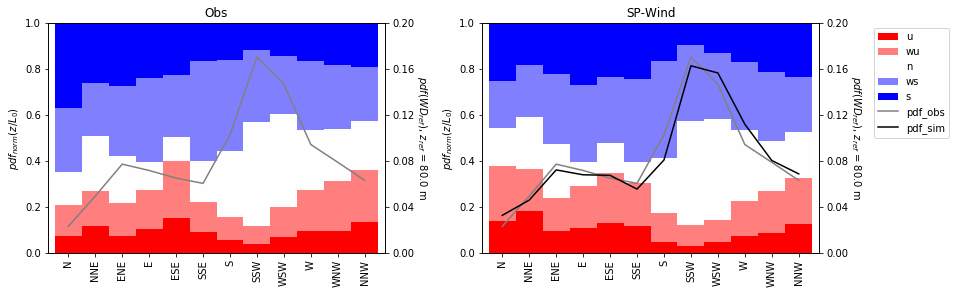

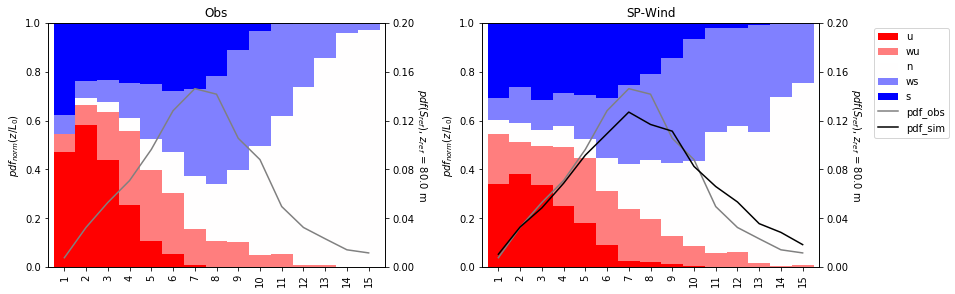

**Fig 2. Annual distributions at 80 m of wind direction (top) and wind speed (bottom)   with bin-based normalized stability distributions according to the classification of Table 2.**

In [65]:
# Select the simulation data to compare against obervations
isim = 3

Nnorm_WDzL_obs = N_WDzL_obs.div(N_WD_obs, axis=0)
Nnorm_WDzL = []
for isim in range(0,Nsim):
    Nnorm_WDzL.append(N_WDzL[isim].div(N_WD[isim], axis=0))
Nnorm_SzL_obs = N_SzL_obs.div(N_S_obs, axis=0)
Nnorm_SzL = []
for isim in range(0,Nsim):
    Nnorm_SzL.append(N_SzL[isim].div(N_S[isim], axis=0))

figname = siteID + '_zLvsWD_dist.png'
fig, axes = plt.subplots(1,2, figsize=(12,4))
cmap = plt.get_cmap('bwr')
zLcolors = np.flipud(cmap(np.linspace(0.,NzL,NzL)/NzL))
ax1=Nnorm_WDzL_obs.plot.bar(ax=axes[0], stacked=True, color=zLcolors, align='center', width=1.0, legend=False, rot=90, use_index = False)
ax2=(N_WD_obs/N_WD_obs.sum()).plot(ax=axes[0], secondary_y=True, style='grey',legend=False, rot=90, use_index = False)
ax2.set_xticklabels(WDbins_label)
ax1.set_title('Obs')
ax1.set_ylabel('$pdf_{norm}$($z/L_0$)')
ax2.set_ylabel('$pdf$($WD_{ref}$), $z_{ref}$ = '+str(zref)+' m', rotation=-90, labelpad=15)
ax1.set_yticks(np.linspace(0,1.,6))
ax1.set_ylim([0,1.])
ax2.set_yticks(np.linspace(0,0.2,6))

ax3=Nnorm_WDzL[isim].plot.bar(ax=axes[1], stacked=True, color=zLcolors, align='center', width=1.0,legend=False, rot=90, use_index = False)
ax4=(N_WD_obs/N_WD_obs.sum()).plot(ax=axes[1], secondary_y=True, style='grey',legend=False, rot=90, use_index = False)
ax4=(N_WD[isim]/N_WD[isim].sum()).plot(ax=axes[1], secondary_y=True, style='k',legend=False, rot=90, use_index = False)
ax4.set_xticklabels(WDbins_label)
ax3.set_title(simID[isim])
ax3.set_ylabel('$pdf_{norm}$($z/L_0$)')
ax4.set_ylabel('$pdf$($WD_{ref}$), $z_{ref}$ = '+str(zref)+' m', rotation=-90, labelpad=15)
ax3.set_yticks(np.linspace(0,1.,6))
ax3.set_ylim([0,1.])
ax4.set_yticks(np.linspace(0,0.2,6))
h1, l1 = ax3.get_legend_handles_labels()
h2, l2 = ax4.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(1.4, 1))
plt.tight_layout(pad=0.4, w_pad=1.2, h_pad=1.2)
#plt.savefig(figname, dpi=300, bbox_inches='tight')
   
figname = siteID + '_zLvsS_dist.png'
fig, axes = plt.subplots(1,2, figsize=(12,4))
ax5=Nnorm_SzL_obs.plot.bar(ax=axes[0], stacked=True, color=zLcolors, align='center', width=1.0, legend=False, rot=90, use_index = False)
ax6=(N_S_obs/N_S_obs.sum()).plot(ax=axes[0], secondary_y=True, style='grey',legend=False, rot=90, use_index = False) 
ax5.set_xticklabels(Sbins_label)
ax5.set_title('Obs')
ax5.set_ylabel('$pdf_{norm}$($z/L_0$)')
ax6.set_ylabel('$pdf$($S_{ref}$), $z_{ref}$ = '+str(zref)+' m', rotation=-90, labelpad=15)
ax5.set_yticks(np.linspace(0,1.,6))
ax5.set_ylim([0,1.])
ax6.set_yticks(np.linspace(0,0.2,6))

ax7=Nnorm_SzL[isim].plot.bar(ax=axes[1], stacked=True, color=zLcolors, align='center', width=1.0,legend=False, rot=90, use_index = False)
ax8=(N_S_obs/N_S_obs.sum()).plot(ax=axes[1], secondary_y=True, style='grey',legend=False, rot=90, use_index = False)
ax8=(N_S[isim]/N_S[isim].sum()).plot(ax=axes[1], secondary_y=True, style='k',legend=False, rot=90, use_index = False)
ax8.set_xticklabels(Sbins_label)
ax7.set_title(simID[isim])
ax7.set_ylabel('$pdf_{norm}$($z/L_0$)')
ax8.set_ylabel('$pdf$($S_{ref}$), $z_{ref}$ = '+str(zref)+' m', rotation=-90, labelpad=15)
ax7.set_yticks(np.linspace(0,1.,6))
ax7.set_ylim([0,1.])
ax8.set_yticks(np.linspace(0,0.2,6))
h1, l1 = ax7.get_legend_handles_labels()
h2, l2 = ax8.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(1.4, 1))
plt.tight_layout(pad=0.4, w_pad=1.2, h_pad=1.2)    
#plt.savefig(figname, dpi=300, bbox_inches='tight')

plt.show()

figcaption = ("**Fig 2. Annual distributions at 80 m of wind direction (top) and wind speed (bottom)  "
              " with bin-based normalized stability distributions according to the classification of Table 2.**")
display(Markdown(figcaption))


## Plot QoI and associated bias vs WD-z/L bins

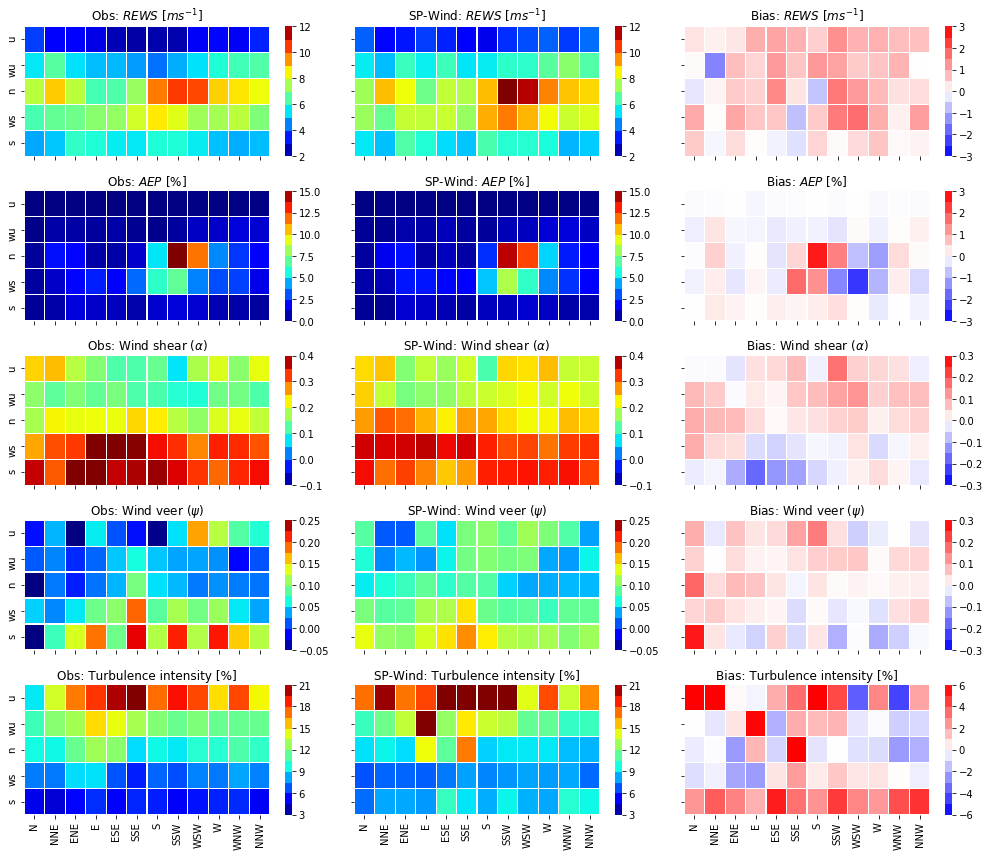

**Fig 4. Heatmaps at 80 m level of observed (left), simulated with SP-Wind (middle) and bias (right) of: REWS, AEP, α wind shear exponent, veer ψ linear-fit slope and turbulence intensity.**

In [66]:
# Select the simulation data to compare against obervations
isim = 3

Z = [REWS_WDzL_obs, REWS_WDzL[isim], Bias_REWS[isim],
         100*AEP_WDzL_obs/AEP_obs_annual, 100*AEP_WDzL[isim]/AEP_annual[isim], 100*AEP_WDzL_obs/AEP_obs_annual - 100*AEP_WDzL[isim]/AEP_annual[isim],
         alpha_WDzL_obs, alpha_WDzL[isim], Bias_alpha[isim],
         veer_WDzL_obs, veer_WDzL[isim], Bias_veer[isim],
         100*I_WDzL_obs, 100*I_WDzL[isim], 100*Bias_I[isim]]

Ztitle = ['Obs', simID[isim], 'Bias']
Zlabel = ('$REWS$ [$m s^{-1}$]','$AEP$ [%]',
                   'Wind shear ('+r'$\alpha$'+')','Wind veer ('+r'$\psi$'+')',
                   'Turbulence intensity [%]')
Xlabel = '$WD_{ref}$'
Ylabel =  '$z/L_0$'

Zlevels = [np.linspace(2,12,11), np.linspace(2,12,11), np.linspace(-3,3,13),            # REWS
           np.linspace(0,15,13), np.linspace(0,15,13), np.linspace(-3,3,13),            # AEP
           np.linspace(-0.1,0.4,11), np.linspace(-0.1,0.4,11), np.linspace(-0.3,0.3,13),# alpha
           np.linspace(-0.05,0.25,13), np.linspace(-0.05,0.25,13), np.linspace(-0.3,0.3,13),# veer    
           np.linspace(3,21,13), np.linspace(3,21,13), np.linspace(-6,6,13)]            # I

Zcmap = [plt.get_cmap('jet'),plt.get_cmap('jet'),plt.get_cmap('bwr')]

figname = siteID+'_'+simID[isim]+'_QoImap.png'
fig, ax = plt.subplots(5, 3, sharex='col', sharey='row', figsize=(14,12))
contourlevels = [50, 100, 200, 300, 400] # contour levels for number of samples
for iax in range (0,15):
    ix,iy = np.unravel_index(iax,(5,3))
    sns.heatmap(Z[iax].T, ax = ax[ix,iy], cmap=Zcmap[iy], 
                vmin=Zlevels[iax].min(), vmax=Zlevels[iax].max(),
                cbar_kws={'boundaries':Zlevels[iax]}, linewidths=.1)
    ax[ix,iy].set_facecolor('grey')
    ax[ix,iy].set_title(Ztitle[iy]+': '+Zlabel[ix])
plt.tight_layout()
#plt.savefig(figname, dpi=300, bbox_inches='tight')

plt.show()

figcaption = ("**Fig 4. Heatmaps at 80 m level of observed (left), simulated with "+simID[isim]+" (middle) "
              "and bias (right) of: REWS, AEP, α wind shear exponent, veer ψ linear-fit slope and "
              "turbulence intensity.**")
display(Markdown(figcaption))


## Mean vertical profiles vs stability for a given wind direction sector 

In [67]:
# Define a wind direction sector to produce mean profiles
sector = {'WSW': [225, 285],  # most frequent
          'ESE': [105, 135],  # GABLS3
          'NNW': [315, 345],
          'N': [345, 360]}    # coastal
sector = sector['WSW']

Sbin = [4.,25.]         # filter relevant velocity range 
WDcenter = 0.5*(sector[0]+sector[1])

# We choose the observed WD and stability to classify bins to make sure we are
# choosing the same timestamps for all the simulations

Uadv['WD0'] = WD_obs['zref']; Uadv['zL0'] = zL_obs; Uadv['S0'] = S_obs['zref']
Uadv_sector = Uadv.loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                  (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:]
Vadv['WD0'] = WD_obs['zref']; Vadv['zL0'] = zL_obs; Vadv['S0'] = S_obs['zref']
Vadv_sector = Vadv.loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                  (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:]
Thadv['WD0'] = WD_obs['zref']; Thadv['zL0'] = zL_obs; Thadv['S0'] = S_obs['zref']
Thadv_sector = Thadv.loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                  (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:]
Ug['WD0'] = WD_obs['zref']; Ug['zL0'] = zL_obs; Ug['S0'] = S_obs['zref']
Ug_sector = Ug.loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                  (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:]
Vg['WD0'] = WD_obs['zref']; Vg['zL0'] = zL_obs; Vg['S0'] = S_obs['zref']
Vg_sector = Vg.loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                  (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:]
S_obs['WD0'] = WD_obs['zref']; S_obs['zL0'] = zL_obs; S_obs['S0'] = S_obs['zref']
S_obs_sector = S_obs.loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                  (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:]
WD_obs['WD0'] = WD_obs['zref']; WD_obs['zL0'] = zL_obs; WD_obs['S0'] = S_obs['zref']
WD_obs_sector = WD_obs.loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                  (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:]
Th_obs['WD0'] = WD_obs['zref']; Th_obs['zL0'] = zL_obs; Th_obs['S0'] = S_obs['zref']
Th_obs_sector = Th_obs.loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                  (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:]
I_obs['WD0'] = WD_obs['zref']; I_obs['zL0'] = zL_obs; I_obs['S0'] = S_obs['zref']
I_obs_sector = I_obs.loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                  (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:]

S_sector = []; WD_sector = []; U_sector = []; V_sector = []; Th_sector = []; I_sector = []
for isim in range(0,Nsim):    
    U[isim]['WD0'] = WD_obs['zref']; U[isim]['zL0'] = zL_obs; U[isim]['S0'] = S_obs['zref']
    U_sector.append(U[isim].loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                           (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:])
    V[isim]['WD0'] = WD_obs['zref']; V[isim]['zL0'] = zL_obs; V[isim]['S0'] = S_obs['zref']
    V_sector.append(V[isim].loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                           (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:])
    Th[isim]['WD0'] = WD_obs['zref']; Th[isim]['zL0'] = zL_obs; Th[isim]['S0'] = S_obs['zref']
    Th_sector.append(Th[isim].loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                           (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:])
    S[isim]['WD0'] = WD_obs['zref']; S[isim]['zL0'] = zL_obs; S[isim]['S0'] = S_obs['zref']
    S_sector.append(S[isim].loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                           (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:])
    WD[isim]['WD0'] = WD_obs['zref']; WD[isim]['zL0'] = zL_obs; WD[isim]['S0'] = S_obs['zref']
    WD_sector.append(WD[isim].loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                           (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:])    
    I[isim]['WD0'] = WD_obs['zref']; I[isim]['zL0'] = zL_obs; I[isim]['S0'] = S_obs['zref']
    I_sector.append(I[isim].loc[lambda df: (df.WD0 >= sector[0]) & (df.WD0 <  sector[1]) &
                                           (df.S0 >= Sbin[0]) & (df.S0 <= Sbin[1]),:])

# Compute mean profiles for each stability class
Uadv_prof = []; Vadv_prof = []; Thadv_prof = [] 
Ug_prof = []; Vg_prof = []
Sadv_prof = []; WDadv_prof = []
Sg_prof = []; WDg_prof = []
S_obs_prof = []; WD_obs_prof = []; Th_obs_prof = []; I_obs_prof = []
Sgadv_prof = []; WDgadv_prof = []
NzL_obs = []

for izL in range(0,NzL):
    Uadv_sector_zL = Uadv_sector.loc[(lambda df: (df.zL0 >= zLbins[izL]) &
                                                (df.zL0 < zLbins[izL+1])),:].values
    Uadv_prof.append(np.nanmean(Uadv_sector_zL, axis = 0))
    Vadv_sector_zL = Vadv_sector.loc[(lambda df: (df.zL0 >= zLbins[izL]) &
                                                (df.zL0 < zLbins[izL+1])),:].values
    Vadv_prof.append(np.nanmean(Vadv_sector_zL, axis = 0))
    Thadv_sector_zL = Thadv_sector.loc[(lambda df: (df.zL0 >= zLbins[izL]) &
                                                (df.zL0 < zLbins[izL+1])),:].values
    Thadv_prof.append(np.nanmean(Thadv_sector_zL, axis = 0))
    Ug_sector_zL = Ug_sector.loc[(lambda df: (df.zL0 >= zLbins[izL]) &
                                             (df.zL0 < zLbins[izL+1])),:].values
    Ug_prof.append(np.nanmean(Ug_sector_zL, axis = 0))
    Vg_sector_zL = Vg_sector.loc[(lambda df: (df.zL0 >= zLbins[izL]) &
                                             (df.zL0 < zLbins[izL+1])),:].values
    Vg_prof.append(np.nanmean(Vg_sector_zL, axis = 0))
    
    Sadv_prof.append((Uadv_prof[izL]**2 + Vadv_prof[izL]**2)**0.5)
    WDadv_prof.append(180. + np.arctan2(Uadv_prof[izL],Vadv_prof[izL])*180./np.pi)
    Sg_prof.append((Ug_prof[izL]**2 + Vg_prof[izL]**2)**0.5)
    WDg_prof.append(180. + np.arctan2(-Vg_prof[izL],Ug_prof[izL])*180./np.pi)
    
    S_obs_sector_zL = S_obs_sector.loc[(lambda df: (df.zL0 >= zLbins[izL]) &
                                                   (df.zL0 < zLbins[izL+1])),:].values
    S_obs_prof.append(np.nanmean(S_obs_sector_zL, axis = 0))
    WD_obs_sector_zL = WD_obs_sector.loc[(lambda df: (df.zL0 >= zLbins[izL]) &
                                                   (df.zL0 < zLbins[izL+1])),:].values
    WD_obs_prof.append(np.nanmean(WD_obs_sector_zL, axis = 0))
    Th_obs_sector_zL = Th_obs_sector.loc[(lambda df: (df.zL0 >= zLbins[izL]) &
                                                   (df.zL0 < zLbins[izL+1])),:].values
    Th_obs_prof.append(np.nanmean(Th_obs_sector_zL, axis = 0))
    I_obs_sector_zL = I_obs_sector.loc[(lambda df: (df.zL0 >= zLbins[izL]) &
                                                   (df.zL0 < zLbins[izL+1])),:].values
    I_obs_prof.append(np.nanmean(I_obs_sector_zL, axis = 0))
    
    NzL_obs.append(S_obs_sector_zL.shape[0])
    
    Sgadv_prof.append(((-Vg_prof[izL]+Uadv_prof[izL])**2 + (Ug_prof[izL]+Vadv_prof[izL])**2)**0.5)
    WDgadv_prof.append(180 + np.arctan2(-Vg_prof[izL]+Uadv_prof[izL],Ug_prof[izL]+Vadv_prof[izL])*180/np.pi)    


U_prof = []; V_prof = []; Th_prof = []; S_prof = []; WD_prof = []; I_prof = []
for isim in range(0,Nsim):
    U_profsim = []; V_profsim = []; Th_profsim = []; S_profsim = []; WD_profsim = []; I_profsim = []
    U_sector_zL = []; V_sector_zL = []; Th_sector_zL = []; I_sector_zL = []
    for izL in range(0,NzL):
        U_sector_zL = U_sector[isim].loc[(lambda df: (df.zL0 >= zLbins[izL]) &
                                               (df.zL0 < zLbins[izL+1])),:].values
        U_profsim.append(np.nanmean(U_sector_zL, axis = 0))
        V_sector_zL = V_sector[isim].loc[(lambda df: (df.zL0 >= zLbins[izL]) &
                                               (df.zL0 < zLbins[izL+1])),:].values
        V_profsim.append(np.nanmean(V_sector_zL, axis = 0))
        Th_sector_zL = Th_sector[isim].loc[(lambda df: (df.zL0 >= zLbins[izL]) &
                                               (df.zL0 < zLbins[izL+1])),:].values
        Th_profsim.append(np.nanmean(Th_sector_zL, axis = 0))    
        I_sector_zL = I_sector[isim].loc[(lambda df: (df.zL0 >= zLbins[izL]) &
                                               (df.zL0 < zLbins[izL+1])),:].values
        I_profsim.append(np.nanmean(I_sector_zL, axis = 0))    
        S_profsim.append((U_profsim[izL]**2 + V_profsim[izL]**2)**0.5)
        WD_profsim.append(180. + np.arctan2(U_profsim[izL],V_profsim[izL])*180./np.pi)
    U_prof.append(U_profsim); V_prof.append(V_profsim); Th_prof.append(Th_profsim)
    S_prof.append(S_profsim); WD_prof.append(WD_profsim); I_prof.append(I_profsim)

## Plot vertical profiles for different stabilities at a given WD sector

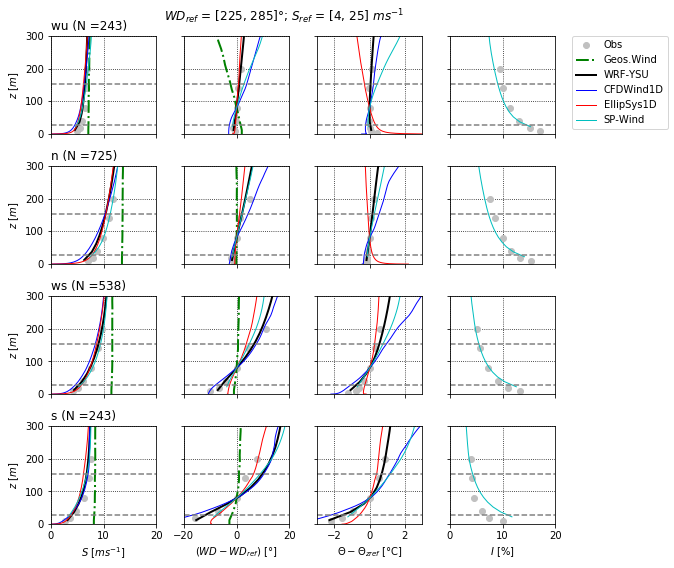

**Fig 3. Ensemble-averaged vertical profiles for the prevailing wind direction sector of horizontalwind speed S (left), wind direction difference $WD-WD_{ref}$ and potential temperature difference $Θ-Θ_{ref}$ with respect to a reference height of $z_{ref}$ = 80.0 m at Cabauw met mast. The geostrophic wind from the reference WRF-YSU simulation is also indicated.**

In [68]:
# Select stability classes to be plotted
zLplot=[1,2,3,4] 
NzLplot = len(zLplot)

ZS = []; zz = []
ZSobs = []; zzobs = []
ZSg = []
iz = np.where(abs(z[isim]-zref)==min(abs(z[isim]-zref)))[0][0]
Nz = len(z[isim])
for izL0 in range(0,NzLplot):
    izL = zLplot[izL0]
    Sref = interpolate.interp1d(zS_obs,S_obs_prof[izL][0:-4])(zref)
    WDref = interpolate.interp1d(zWD_obs,WD_obs_prof[izL][0:-4])(zref)
    Thref = interpolate.interp1d(zT_obs,Th_obs_prof[izL][0:-4])(zref)
    Sgref = interpolate.interp1d(ztend,Sg_prof[izL][0:-3])(zref)
    WDgref = interpolate.interp1d(ztend,WDg_prof[izL][0:-3])(zref)
    WDdiff = WD_obs_prof[izL][0:-4]-WDref
    WDdiff[abs(WDdiff)>180] = WDdiff[abs(WDdiff)>180] - np.sign(WDdiff[abs(WDdiff)>180])*360.        
    ZSobs.append((S_obs_prof[izL][0:-4], WDdiff, Th_obs_prof[izL][0:-4]-Thref, 100*I_obs_prof[izL][0:-4]))
    zzobs.append((zS_obs, zWD_obs, zT_obs, zS_obs))
    ZSg.append((Sg_prof[izL][0:-3], WDg_prof[izL][0:-3]-WDgref))

ZS = []; zz = []
for isim in range(0,Nsim):
    ZSzL = []; zzzL = []    
    for izL0 in range(0,NzLplot):
        izL = zLplot[izL0]
        Sref = interpolate.interp1d(z[isim],S_prof[isim][izL][0:-3])(zref)
        WDref = interpolate.interp1d(z[isim],WD_prof[isim][izL][0:-3])(zref)
        Thref = interpolate.interp1d(z[isim],Th_prof[isim][izL][0:-4])(zref)
        WDdiff = WD_prof[isim][izL][0:-3]-WDref
        WDdiff[abs(WDdiff)>180] = WDdiff[abs(WDdiff)>180] - np.sign(WDdiff[abs(WDdiff)>180])*360.        
        ZSzL.append((S_prof[isim][izL][0:-3], WDdiff, Th_prof[isim][izL][0:-4]-Thref,100*I_prof[isim][izL][0:-4]))
        zzzL.append((z[isim],z[isim],z[isim],z[isim]))
    ZS.append(ZSzL)
    zz.append(zzzL)
     
        
ZSlabel = (('$S$ [$m s^{-1}$]', '$(WD-WD_{ref})$ ['+u'\N{DEGREE SIGN}'+']',
            '$\Theta-\Theta_{zref}$ ['+u'\N{DEGREE SIGN}'+'C]','$I$ [%]'))
ZSlim =  [[0, 20],[-20., 20],[-3, 3],[0, 20]]

figname = siteID+"%.0f"%(WDcenter)+'_SWDThprof.png'
zLcolors[4] = np.array([0,0,0,1]) # neutral color = black

fig,ax = plt.subplots(nrows=len(zLplot), ncols=4, sharex='col', sharey='row', figsize=(8,8))
Nticks = 5
yrotor1 = np.array([Hhub - 0.5*Drot, Hhub - 0.5*Drot])
yrotor2 = np.array([Hhub + 0.5*Drot, Hhub + 0.5*Drot])
zlim = 300.0
for iax in range (0,NzLplot*4):
    ix,iy = np.unravel_index(iax,(NzLplot,4))
    ax[ix,iy].plot(ZSobs[ix][iy],zzobs[ix][iy],'ok', color = 'silver', label = 'Obs')
    if iy == 0:
        ax[ix,iy].plot(ZSg[ix][iy], ztend, '-.g', label = 'Geos.Wind', linewidth = 2)
        ax[ix,iy].set_title(zLbins_label[zLplot[ix]]+' (N =' + str(NzL_obs[zLplot[ix]])+')', loc = 'left')
    if iy == 1:
        ax[ix,iy].plot(ZSg[ix][iy], ztend, '-.g', label = 'Geos.Wind', linewidth = 2)
    for isim in range(0,Nsim):
        ax[ix,iy].plot(ZS[isim][ix][iy][1:], zz[isim][ix][iy][1:],
          linestylesim[isim], linewidth = linewidthsim[isim], label = simID[isim])
    
    ax[ix,iy].grid(which='major',color='k',linestyle=':')
    ax[ix,iy].plot(ZSlim[iy],yrotor1,'--',color = 'grey')
    ax[ix,iy].plot(ZSlim[iy],yrotor2,'--',color = 'grey')
    ax[ix,iy].set_ylim([0, zlim])
    ax[ix,iy].set_xlim(ZSlim[iy])
    if iy == 0:
        ax[ix,iy].set_ylabel('$z$ [$m$]')
    if ix == NzLplot-1:
        ax[ix,iy].set_xlabel(ZSlabel[iy])
    if iax == 0:
        ax[ix,iy].legend(bbox_to_anchor=(5.9, 1.05))
plt.suptitle('$WD_{ref}$ = ['+"%.0f"%(sector[0])+', '+"%.0f"%(sector[1])+']'+u'\N{DEGREE SIGN}'+
             '; $S_{ref}$ = ['+"%.0f"%(Sbin[0])+', '+"%.0f"%(Sbin[1])+'] $m s^{-1}$')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
#plt.savefig(figname, dpi=300, bbox_inches='tight')

plt.show()

figcaption = ("**Fig 3. Ensemble-averaged vertical profiles for the prevailing wind direction sector of horizontal"
              "wind speed S (left), wind direction difference $WD-WD_{ref}$ and potential temperature difference "
              "$Θ-Θ_{ref}$ with respect to a reference height of $z_{ref}$ = "+str(zref)+" m at Cabauw met mast. The "
              "geostrophic wind from the reference WRF-YSU simulation is also indicated.**")
display(Markdown(figcaption))